# Homework Exercise I

Full Name: Vasileios Lioutas

For the first assigment I decided to use the [autograd package](https://github.com/HIPS/autograd) for numpy. I have also tested the same code in PyTorch and Tensorflow Eager but found that autograd package  was a few seconds faster in CPU execution for such a small repeated task.

## Step 1 - Exporing simulated data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pandas as pd
import os

np.random.seed(100)

### Question A

Below is the implementation of the first question.

In [5]:
def f(x):
    return np.cos(2*np.pi*x)

def getData(N, sigma):
    x = np.random.uniform(size=N)
    y = f(x)
    y_noisy = y + np.random.normal(scale=sigma, size=N)
    
    return x, y_noisy

The following plots depict the distribution of the generated data points.

It is obvious that **the smaller the sigma value is, the less noisy the data is** given the true function defined in f(x) above. 

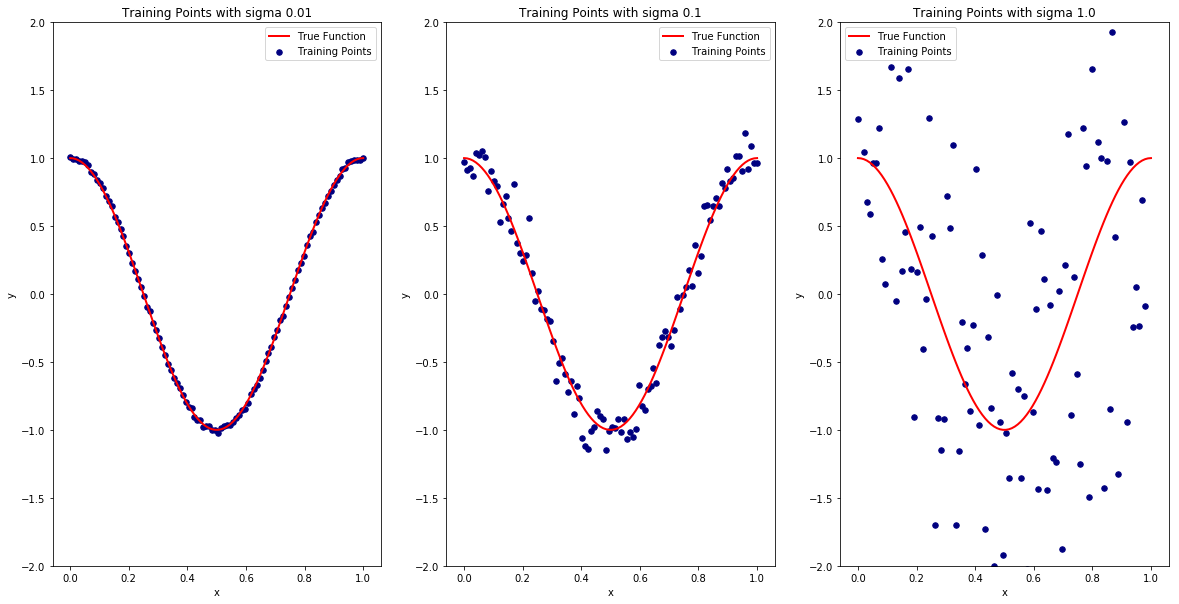

In [137]:
sigmas_plot = [0.01, 0.1, 1.0]
x_plot = np.linspace(0, 1, 100)
y_plot = f(x_plot)

plt.figure(figsize=(20, 10))

for i in range(len(sigmas_plot)):
    plt.subplot(1, len(sigmas_plot), i + 1)
    
    y = y_plot + np.random.normal(scale=sigmas_plot[i], size=100)
    plt.plot(x_plot, y_plot, color="red", linewidth=2, label="True Function")
    plt.scatter(x_plot, y, color='navy', s=30, marker='o', label="Training Points")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-2, 2)
    plt.legend(loc="best")
    plt.title("Training Points with sigma {}".format(sigmas_plot[i]))

plt.show()

## Step 2 - Implement the code of experiment

### Question B 

Below is the implementation of the second question.

In [6]:
def model(w, x):
    """
    Here is defined the base model structure. It accepts as inputs the coefficients of the polynomial 
    (as a vector w) and the input x and computes the output value.
        
    Parameters
    ----------
    w : numpy vector of size the degree of the polynomial
    x : numpy vector containing the input data 
    
    Returns
    -------
    The output of the model.
    """
    
    y = 0
    for i in range(w.shape[0]):
        y += w[i] * x ** i
    return y 

def getMSE(w, x, y):
    """
    The function is responsible to calculate the Mean Square Error (MSE) 
    for a given set of coefficients, inputs and correct output values.
        
    Parameters
    ----------
    w : numpy vector of size the degree of the polynomial
    x : numpy vector containing the input data
    y : numpy vector containing the correct output values
    
    Returns
    -------
    The calculated MSE.
    """
    
    y_hat = model(w, x)
    err = y_hat - y
    mse = np.mean(err ** 2)
    return mse

def apply_l2_regularization(w, x, y, weight_decay = 0.0):
    """
    The function is responsible to apply L2 regularization (Weight Decay) on top of the MSE loss.
    This function is meant to be used only for training.
        
    Parameters
    ----------
    w : numpy vector of size the degree of the polynomial
    x : numpy vector containing the input data
    y : numpy vector containing the correct output values
    weight_decay : the regularization factor
    
    Returns
    -------
    The calculated MSE with weight decay.
    """
    
    l2_reg = 0
    if weight_decay != 0:
        l2_reg = np.sum(w ** 2)
        
    return getMSE(w, x, y) + 1/x.shape[0] * weight_decay/2 * l2_reg

### Question C

Below is the implementation of the function fitData().

Running a signle experiment on my laptop for more than 10000 iterations takes more than 1.5 minutes, so running each experiment 20 (or more as recommended) times for each hyperparameter combination that question E requires would take at the very least a couple of days to finish. Due to this, I decided to run each experiment for only 1000 iterations and increase the learning rate to 0.1. For this to work though I had to include a gradient clipping method as defined below due to the exploding gradient issue.

![title](images/norm_clipping.png)

In [7]:
def fitData(x, y, d, sigma, weight_decay = 0.0):
    """
    The function is responsible to get a set of training data (x, y), 
    the sigma that has been used to generate those data, the degree of the desired polynomial to be fitted 
    and optionally the weight decay factor using Mini-batch gradient descent.
        
    Parameters
    ----------
    x : numpy vector containing the input data
    y : numpy vector containing the correct output values
    d : int - the degree of the polynomial to create
    sigma : float - the sigma (noise) that has been used to generate y values
    weight_decay : (optional) float - the L2 regularization factor
    
    Returns
    -------
    A triple of the calculated coefficients, the MSE of the training data 
    and the MSE of a new generated testing data
    """
    
    weights = np.random.normal(size=(d+1)) # initialize the coefficients of the polynomial functions given the degree
    grad_fn = grad(apply_l2_regularization) # compute a gradient function from the MSE function (using weight decay)

    N = x.shape[0] # number of examples
    
    learning_rate= 0.1 # step size 
    iters = 1000 # number of epochs to run
    batch_size = 20 # fix number of batch size - in case of sample size less than 20 the algorithm works as simple gradient descent
    clip_threshold = 5 # gradient clipping threshold

    for i in range(iters):
        permutation = np.random.permutation(N) # create a random permutation between 0 and N to shuffle the mini-batches each epoch

        for b in range(0, N, batch_size):
            indices = permutation[b:b+batch_size]
            batch_x, batch_y = x[indices], y[indices] # get the mini-batch 
            
            gradient = grad_fn(weights, batch_x, batch_y, weight_decay) # computation of the gradients
            
            # Here we apply gradient clipping
            total_norm = np.linalg.norm(gradient, 2)
            if total_norm >= clip_threshold:
                gradient = (clip_threshold/total_norm) * gradient

            # update the weights with the new gradients
            weights -= gradient * learning_rate
            
    e_in = getMSE(weights, x, y) # compute MSE for training set

    x_test, y_test = getData(1000, sigma) # generate new testing set of size 1000
    e_out = getMSE(weights, x_test, y_test) # compute MSE for the new testing set

    return weights, e_in, e_out

### Question D

As I mentioned earlier, running each experiment takes way more time than my available resources. For this reason, I used the minimun required number of experiments (20).

In [8]:
def experiment(N, d, sigma, weight_decay = 0):
    """
    The function is responsible to execute an experiment for a given number of example
    and the degree of the desired polynomial to be fitted.
        
    Parameters
    ----------
    N : int - the number of examples to be generated
    d : int - the degree of the polynomial to be fitted
    sigma : float - the sigma (noise) that has been used to generate the datasets
    weight_decay : (optional) float - the L2 regularization factor
    
    Returns
    -------
    A triple of the calculated average MSE of the training data from all the experiments, 
    the average MSE of the testing data from all the experiments and the MSE of a new generated dataset
    using the average coefficients from all experiments
    """
    
    M = 20 # the number of the experiments to run
    e_in_sum = 0
    e_out_sum = 0
    weights_sum = None
    
    for m in range(M):
        x, y = getData(N, sigma)
        weights, e_in, e_out = fitData(x, y, d, sigma, weight_decay=weight_decay)
        e_in_sum += e_in
        e_out_sum += e_out
        if weights_sum is None:
            weights_sum = weights
        else:
            weights_sum += weights
            
    e_in_mean = e_in_sum / M
    e_out_mean = e_out_sum / M
    weights_mean = weights_sum / M

    x_bias, y_bias = getData(1000, sigma)

    e_bias = getMSE(weights_mean, x_bias, y_bias)

    return e_in_mean, e_out_mean, e_bias

### Question E/F

Below I'm running the experiments for all the desired combinations of the hyperparameters including two different settings for weight decay as instructed in Question F. The final results as saved in a csv file which is included in the compressed zip file. The total time to run all this experiments was more than 1.5 day.

In [ ]:
N = [2, 5, 10, 20, 50, 100, 200]
D = [i for i in range(21)]
sigma = [0.01, 0.1, 1]
weight_decay = [0.0, 0.1]

counter = 0

filename = "results_final.csv"

if os.path.exists(filename):
    os.remove(filename)

with open(filename, 'a+') as out:
   out.write("N,"+"d,"+"sigma,"+"weight_decay,"+"e_in_mean,"+"e_out_mean,"+"e_bias"+'\n')

for n in N:
    for d in D:
        for s in sigma:
            for w_d in weight_decay:
                counter += 1
                e_in, e_out, e_bias = experiment(n, d, s, w_d)
                
                line = str(n)+","+str(d)+","+str(s)+","+str(w_d)+","+str(e_in)+","+str(e_out)+","+str(e_bias)
                print(counter, line)

                with open(filename, 'a+') as out:
                   out.write(line + '\n')

## Step 3 - Visualizing Results

In [3]:
results = pd.read_csv("results_final.csv")
results.head()

,N,d,sigma,weight_decay,e_in_mean,e_out_mean,e_bias
0,2,0,0.01,0.0,0.230655,0.800438,0.483898
1,2,0,0.01,0.1,0.245927,0.791643,0.507241
2,2,0,0.10,0.0,0.261574,0.797338,0.515627
3,2,0,0.10,0.1,0.258904,0.780522,0.564363
4,2,0,1.00,0.0,0.584863,2.357039,1.441748


### Underfitting vs. Overfitting plots

The following plots are showing how well the model is able to learn given diffenent values of degrees for different number of training sample sizes.

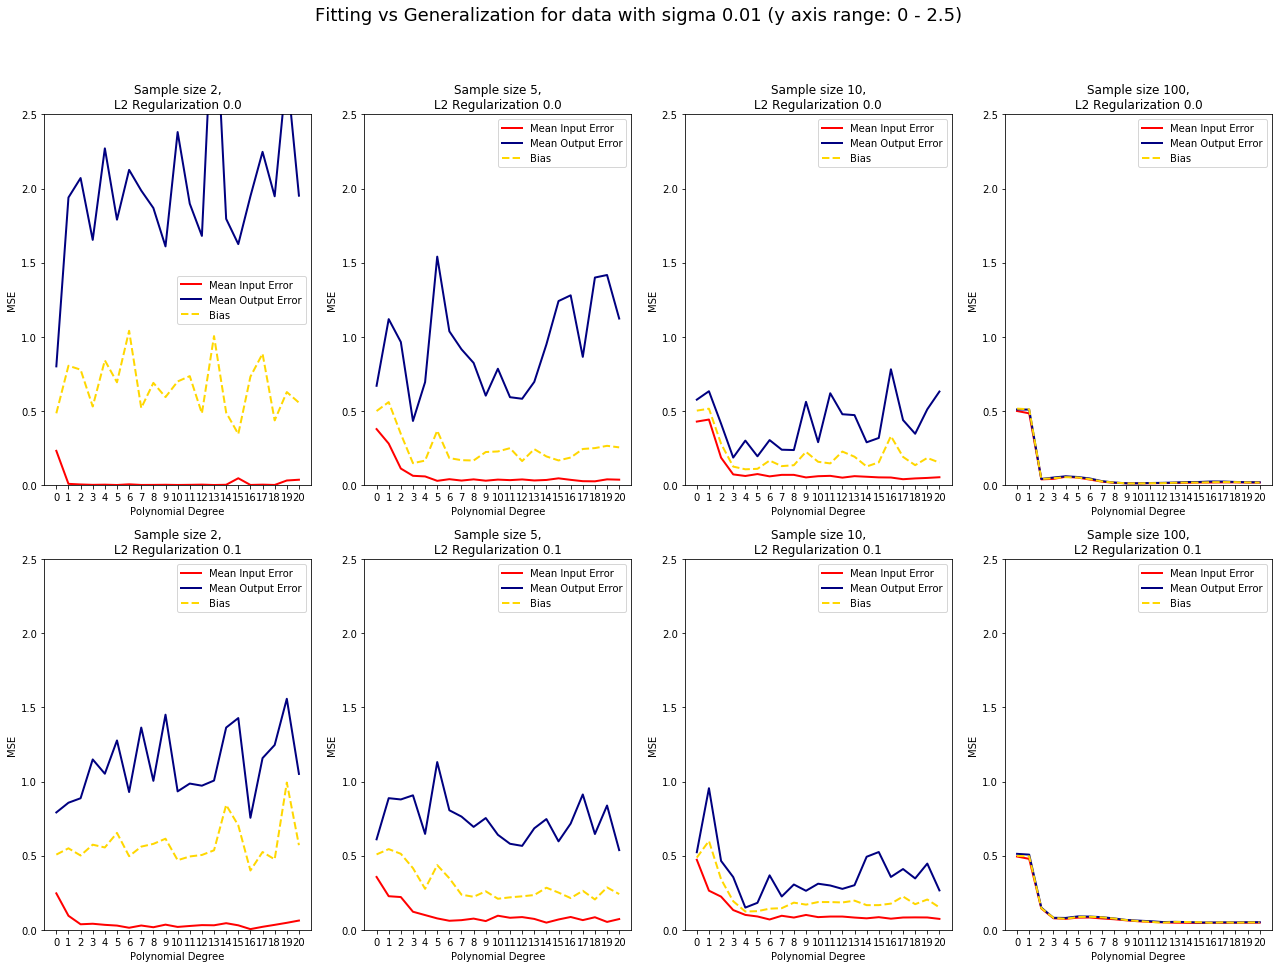

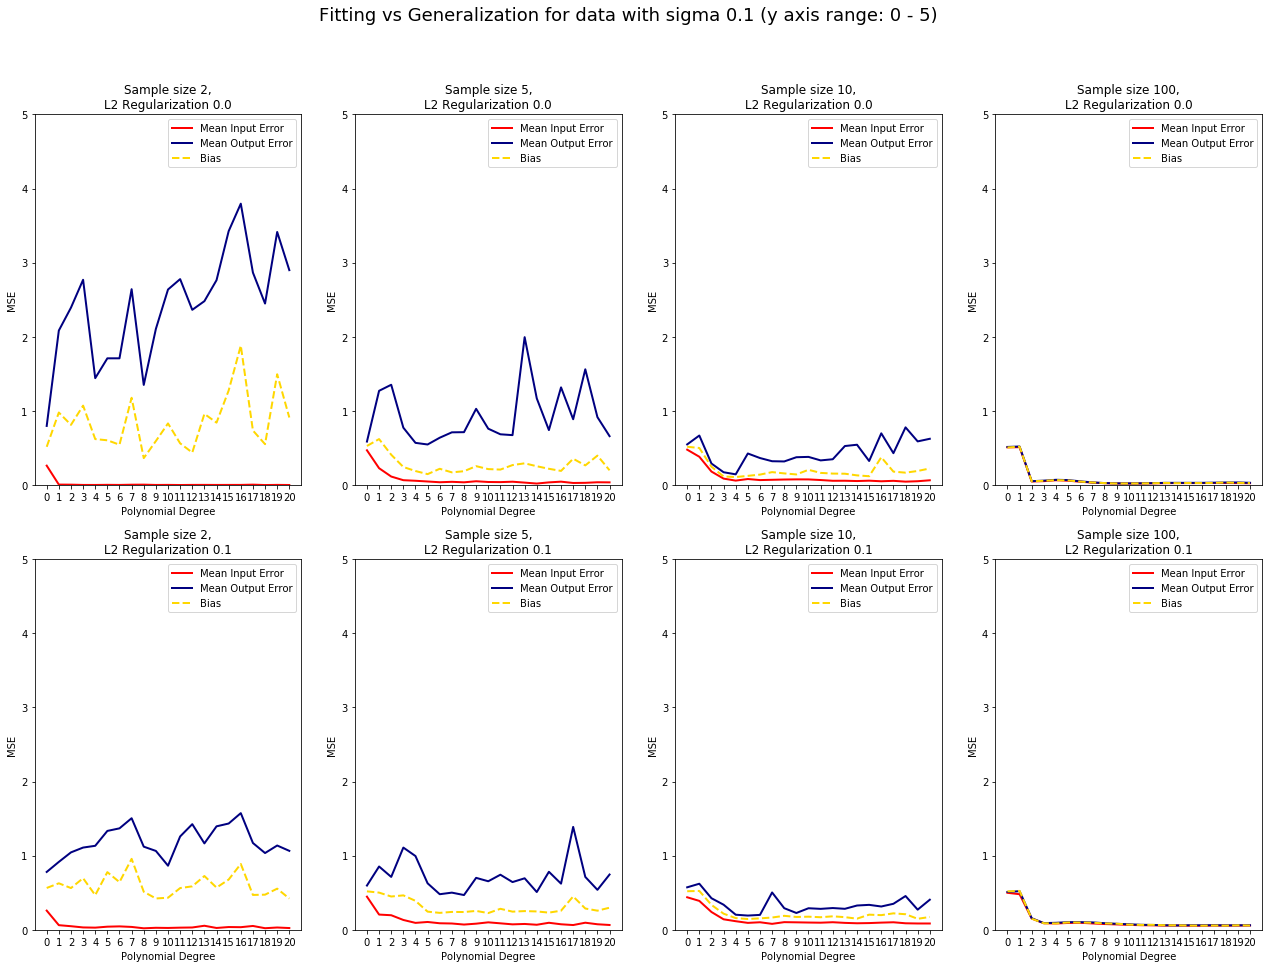

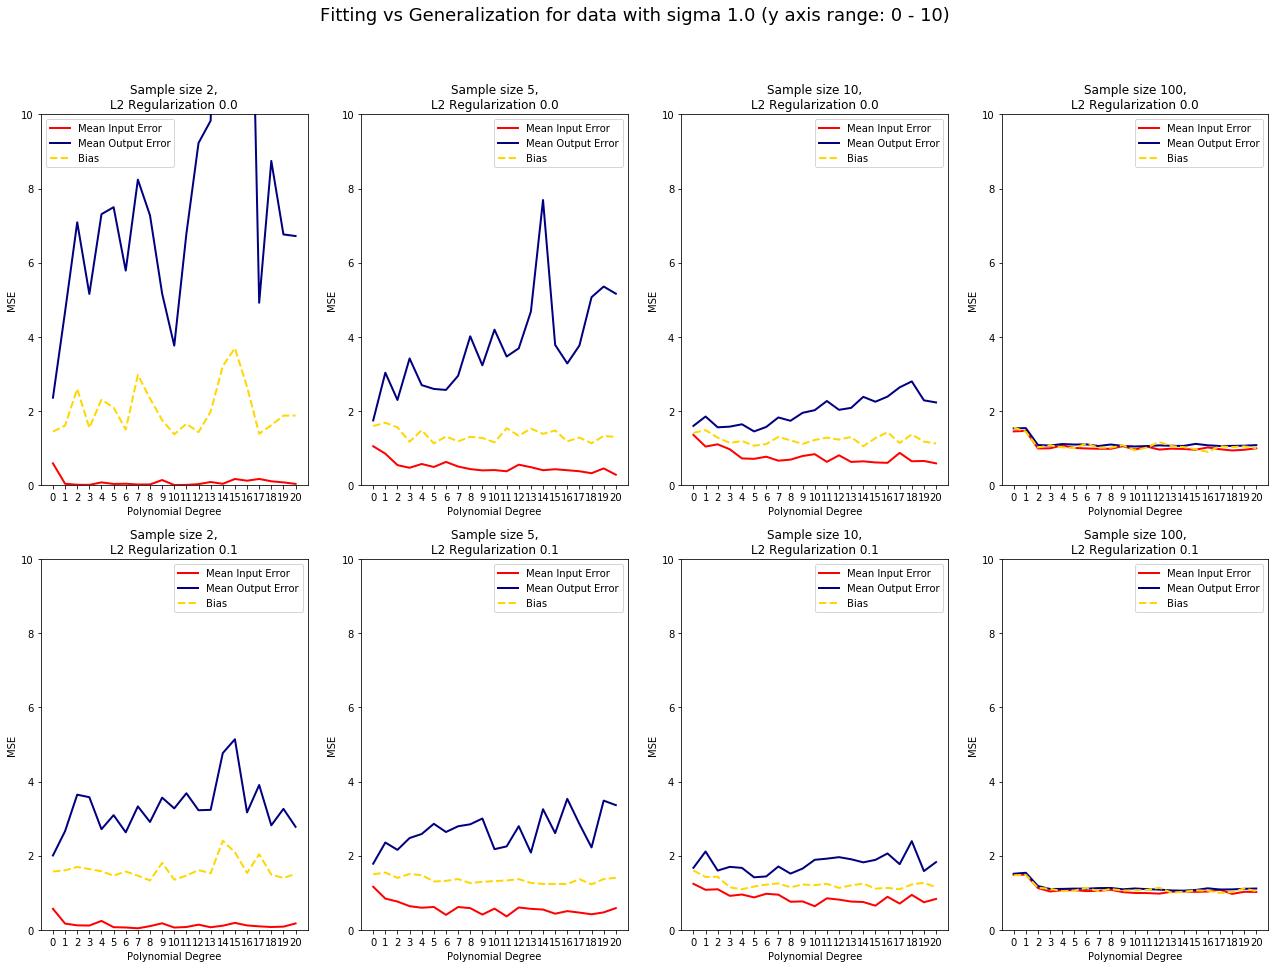

In [6]:
N = [2, 5, 10, 100]
weight_decays = [0.0, 0.1]

plt.figure(figsize=(22, 15))
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==0.01) & (results['weight_decay']==0.0)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 2.5)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.0))  
    
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), len(N) + i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==0.01) & (results['weight_decay']==0.1)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 2.5)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.1))  

plt.suptitle("Fitting vs Generalization for data with sigma 0.01 (y axis range: 0 - 2.5)", fontsize=18)
plt.show()

print()

plt.figure(figsize=(22, 15))
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==0.1) & (results['weight_decay']==0.0)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 5)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.0))  
    
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), len(N) + i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==0.1) & (results['weight_decay']==0.1)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 5)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.1))  

plt.suptitle("Fitting vs Generalization for data with sigma 0.1 (y axis range: 0 - 5)", fontsize=18)
plt.show()

print()

plt.figure(figsize=(22, 15))
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==1.0) & (results['weight_decay']==0.0)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 10)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.0))  
    
for i in range(len(N)):
    plt.subplot(len(weight_decays), len(N), len(N) + i + 1)

    test = results[(results['N']==N[i]) & (results['sigma']==1.0) & (results['weight_decay']==0.1)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    ebias = test['e_bias'].reset_index(drop=True)
    x = test['d'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.plot(x, ebias, '--', color='gold', linewidth=2, label="Bias")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.ylim(0, 10)
    plt.legend(loc="best")
    plt.title("Sample size {},\nL2 Regularization {}".format(N[i], 0.1))  

plt.suptitle("Fitting vs Generalization for data with sigma 1.0 (y axis range: 0 - 10)", fontsize=18)
plt.show()

When the level of noise is small (sigma 0.01) it is expected that the model will generalize well given enough examples. This can be seen in the plot where the sample size is 100. For the case when the sample size is 2, the model is not able to learn the true distribution of the data and thus it overfits very quickly (the output error rises after the 2nd degree). The same thing applies for a sample size of 5 when the degree is larger than 3. When the degree is 3 the model is able to generalize better than previous simpler models. For a sample size 10, things become more clear as it is obvious that a 3rd degree polynomial is the best model to generalize. If we introduce a 0.1 weight decay, we notice that the generalization error is lower in all cases and more stable.

When the noise is 0.1, the results are much worse as the models are struggling more to find the true distribution of the data. Again for a sample size of 100 the model is able to learn f(x) and to generalize well. L2 regularization is still helping generalization.

In the case of sigma 1.0, the models are not able to undestand the true function as in all cases the output error is way more higher than the previous cases of sigma.

### Plotting Learning Curves

The following plots are showing the learning curves for different complexities as we raising the number of examples.

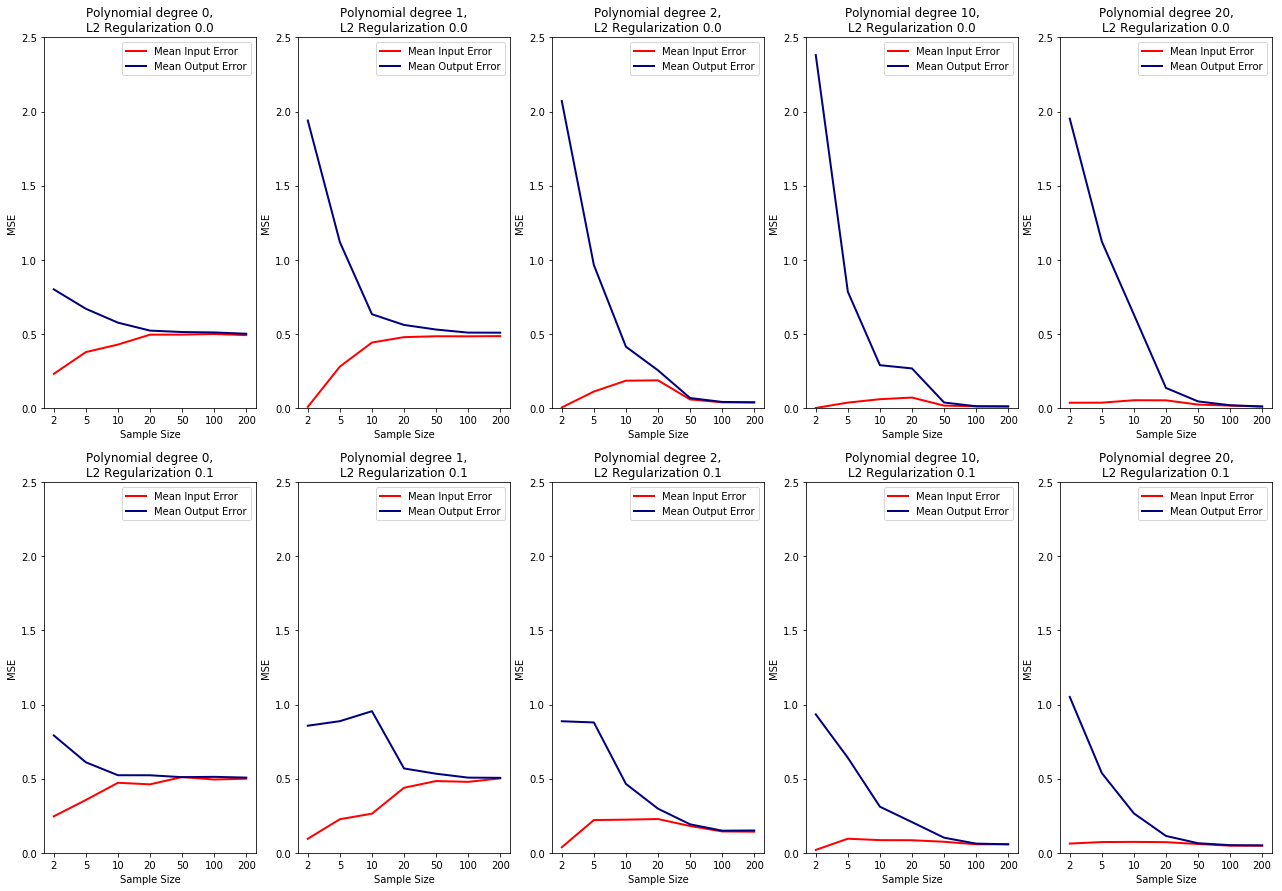

In [119]:
degrees = [0, 1, 2, 10, 20]
weight_decays = [0.0, 0.1]

plt.figure(figsize=(22, 15))
for i in range(len(degrees)):
    plt.subplot(len(weight_decays), len(degrees), i + 1)

    test = results[(results['d']==degrees[i]) & (results['sigma']==0.01) & (results['weight_decay']==0.0)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    x = test['N'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.xlabel("Sample Size")
    plt.ylabel("MSE")
    plt.ylim(0, 2.5)
    plt.legend(loc="best")
    plt.title("Polynomial degree {},\nL2 Regularization {}".format(degrees[i], 0.0))  
    
for i in range(len(degrees)):
    plt.subplot(len(weight_decays), len(degrees), len(degrees) + i + 1)

    test = results[(results['d']==degrees[i]) & (results['sigma']==0.01) & (results['weight_decay']==0.1)]
    ein = test['e_in_mean'].reset_index(drop=True)
    eout = test['e_out_mean'].reset_index(drop=True)
    x = test['N'].reset_index(drop=True).astype(str)

    x_plot = np.linspace(0, 1, 100)
    y_plot = f(x_plot) + np.random.normal(scale=0.01, size=100)
    plt.plot(x, ein, color='red', linewidth=2, label="Mean Input Error")
    plt.plot(x, eout, color='navy', linewidth=2, label="Mean Output Error")
    plt.xlabel("Sample Size")
    plt.ylabel("MSE")
    plt.ylim(0, 2.5)
    plt.legend(loc="best")
    plt.title("Polynomial degree {},\nL2 Regularization {}".format(degrees[i], 0.1))  
    
plt.show()

It can be seen from the graphs that when the model is less simple the training error becomes very low at the beginning and increases later on whereas the testing error is very high at the beginning and descreases later on. On the other hand, with a more complex model, the training error plateaus around the minimum value meaning that it can overfit no matter the size of the data and the testing error could be descreased with more training samples. Regularization helps as the testing error descreases faster.